<a href="https://colab.research.google.com/github/Piligrimich/Piligrimich/blob/main/UNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!gdown https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7 -O PH2Dataset.rar

Downloading...
From: https://drive.google.com/uc?id=1D5kZvea81dGRnmCXXolNJ4TL-MDksti7
To: /content/PH2Dataset.rar
100% 116M/116M [00:00<00:00, 302MB/s] 


In [2]:
get_ipython().system_raw('unrar x PH2Dataset.rar')

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs,files in os.walk(os.path.join(root,'PH2 Dataset images')):
  if root.endswith('_Dermoscopic_Image'):
    images.append(imread(os.path.join(root,files[0])))
  if root.endswith('_lesion'):
    lesions.append(imread(os.path.join(root,files[0])))
    

In [4]:
from skimage.transform import resize
size = (256,256)
X = [resize(x, size,mode='constant',anti_aliasing=True,) for x in images]
Y = [resize(y, size,mode='constant',anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X,np.float32)
Y = np.array(Y,np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


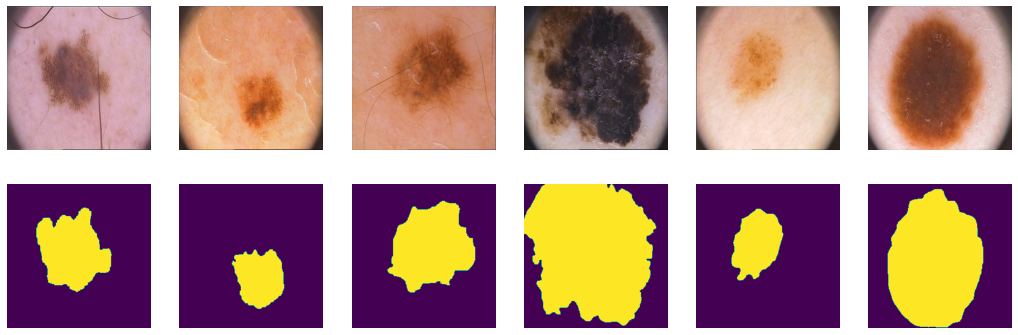

In [6]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18,6))
for i in range(6):
  plt.subplot(2,6,i+1)
  plt.axis("off")
  plt.imshow(X[i])

  plt.subplot(2,6,i+7)
  plt.axis("off")
  plt.imshow(Y[i])

plt.show()

In [7]:
ix = np.random.choice(len(X),len(X),False)
tr, val, ts = np.split(ix,[100,150])

In [97]:
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(X[tr],3,1), Y[tr,np.newaxis])),
                     batch_size=batch_size,shuffle=True)
data_vl = DataLoader(list(zip(np.rollaxis(X[val],3,1),Y[val,np.newaxis])),
                     batch_size=batch_size,shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts],3,1),Y[ts,np.newaxis])),
                     batch_size=batch_size,shuffle=True)

In [9]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision.datasets as dset
from torchvision import transforms

import matplotlib.pyplot as plt


In [11]:
import torch.nn.functional as F
from torchvision import models
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [12]:
from collections import OrderedDict
class UNet(nn.Module):
  @staticmethod
  def _convolution(in_c,out_c,name):
    return nn.Sequential(
        OrderedDict(
            [
             (
                 name+"conv1",
              nn.Conv2d(in_c,
                        out_c,
                        kernel_size=3,
                        padding=1,
                        bias=False
                        ),
              
             ),
             (name+"norm1",nn.BatchNorm2d(out_c)),
             (name+"relu1",nn.ReLU(inplace=True)),
             (
                 name+"conv2",
              nn.Conv2d(out_c,
                        out_c,
                        kernel_size=3,
                        padding=1,
                        bias=False),
             ),
             (name+"norm2",nn.BatchNorm2d(out_c)),
             (name+"relu2",nn.ReLU(inplace=True))
            ]
        )
        
    )
  def __init__(self,in_c = 3,out_c = 1,init_features=32):
    super(UNet,self).__init__()

    features = init_features
    self.encoder1  = UNet._convolution(in_c,features,name='enc1')
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.encoder2 = UNet._convolution(features,features*2,name="enc2")
    self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.encoder3 = UNet._convolution(features*2,features*4,name="enc3")
    self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.encoder4 = UNet._convolution(features*4,features*8,name="enc4")
    self.pool4 = nn.MaxPool2d(kernel_size=2,stride=2)

    self.bottleneck = UNet._convolution(features*8,features*16,name="bottleneck")

    self.upconv4 = nn.ConvTranspose2d(features*16,features*8,kernel_size=2,stride=2)

    self.decoder4 = UNet._convolution((features*8)*2,features*8,name="dec4")
    self.upconv3 = nn.ConvTranspose2d(features*8,features*4,kernel_size=2,stride=2)

    self.decoder3 = UNet._convolution((features * 4) * 2, features * 4, name="dec3")
    self.upconv2 = nn.ConvTranspose2d(
        features * 4, features * 2, kernel_size=2, stride=2
    )

    self.decoder2 = UNet._convolution((features * 2) * 2, features * 2, name="dec2")
    self.upconv1 = nn.ConvTranspose2d(
        features * 2, features, kernel_size=2, stride=2
    )

    self.decoder1 = UNet._convolution(features * 2, features, name="dec1")

    self.conv = nn.Conv2d(
        in_channels=features, out_channels=out_c, kernel_size=1
    )

  def forward(self,x):
    enc1 = self.encoder1(x)
    enc2 = self.encoder2(self.pool1(enc1))
    enc3 = self.encoder3(self.pool2(enc2))
    enc4 = self.encoder4(self.pool3(enc3))

    bottleneck = self.bottleneck(self.pool4(enc4))

    dec4 = self.upconv4(bottleneck)
    dec4 = torch.cat((dec4, enc4), dim=1)
    dec4 = self.decoder4(dec4)
    dec3 = self.upconv3(dec4)
    dec3 = torch.cat((dec3, enc3), dim=1)
    dec3 = self.decoder3(dec3)
    dec2 = self.upconv2(dec3)
    dec2 = torch.cat((dec2, enc2), dim=1)
    dec2 = self.decoder2(dec2)
    dec1 = self.upconv1(dec2)
    dec1 = torch.cat((dec1, enc1), dim=1)
    dec1 = self.decoder1(dec1)
    return torch.sigmoid(self.conv(dec1))


In [13]:
def train(model,opt,loss_fn, epochs, data_tr,data_val):
  X_val,Y_val = next(iter(data_val))
  
  for epoch in range(epochs):
    tic = time()
    print('* Epoch %d/%d' % (epoch+1,epochs))

    avg_loss = 0
    model.train()
    for X_batch,Y_batch in data_tr:
      X_batch,Y_batch = X_batch.to(device),Y_batch.to(device)
      opt.zero_grad()
      Y_pred = model(X_batch)
       
      loss = loss_fn(Y_pred.squeeze(),Y_batch.squeeze())
      loss.backward()
      opt.step()
      

      avg_loss += loss / len(data_tr)
    toc = time()
    print(f'losss: {loss}')

    model.eval()
  
    for X,_ in data_val:
      X = X.to(device)

      pred = model(X)
      pred = pred.to('cpu')
      X = X.to('cpu')
      for k in range(5):
        plt.subplot(2, 6, k+1)
        plt.imshow(np.rollaxis(X[k].detach().numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(2, 6, k+7)
        plt.imshow(pred[k].squeeze().detach().numpy(), cmap='gray')
        plt.title('Output')
        plt.axis('off')
      plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
      plt.show()

In [14]:
model = UNet().to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()

In [16]:
optimizer = torch.optim.Adam(model.parameters())

In [50]:
max_epochs = 20

In [ ]:
train(model, optimizer, loss_fn, max_epochs, data_tr, data_vl)

In [178]:
def iou_pytorch(outputs, labels):
    outputs = outputs.squeeze(1).round().int() 
    labels = labels.squeeze(1).round().int()
    
    intersection = (outputs & labels).sum((1, 2))  
    union = (outputs | labels).sum((1, 2))         
  
    iou = (intersection) / (union)  
    
    return iou  

In [183]:
def score_model(model, metric, data):
    model.eval()  
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        scores += metric(Y_pred, Y_label.to(device)).mean().item()
    
    return scores/len(data)

In [186]:
score_model(model, iou_pytorch, data_vl)

0.5507869094610214